## 机器学习进阶（S13）毕业项目 - 猫狗大战

## 项目：识别图片中是猫还是狗
---
* 此项目是kaggle平台上的一个比赛项目，最终的要求是提供一个模型来识别图片中的对象是猫还是狗。
* 这里会使用深度学习中的卷积神经网络来构建模型。
* 最总要求测试评分进入 kaggle Public Leaderboard 前10%。

## 步骤 1: 数据探索

#### 准备

In [1]:
import os
import shutil
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from tqdm import tqdm
import numpy as np
import pandas as pd  
                      
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.inception_resnet_v2 import *
from keras.applications.xception import *
from keras.applications.inception_v3 import *

from operator import is_not
from functools import partial
from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint  
from keras.optimizers import SGD

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 载入数据

In [2]:
# 读取训练集
train_files = os.listdir('train')
print(train_files[0:10])

['dog.9220.jpg', 'dog.4153.jpg', 'cat.4113.jpg', 'dog.7547.jpg', 'cat.7459.jpg', 'dog.10028.jpg', 'cat.11954.jpg', 'cat.7368.jpg', 'dog.3505.jpg', 'cat.12057.jpg']


#### 寻找异常

In [3]:
# 定义ImageNet中识别猫狗的分类 https://blog.csdn.net/zhangjunbob/article/details/53258524
dogs = [
 'n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364','n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721','n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437','n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177','n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251','n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185','n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889','n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']

cats=['n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']



#存储不能识别为猫狗的异常图片
my_unknow_images = []


# 根据模型预测的结果查看是否属于猫狗的范围
def is_cat_dog(preds_result):
    my_labels = dogs[:]
    my_labels[len(my_labels):len(my_labels)] = cats
    a = [x[0] in my_labels for x in preds_result]
#     print(sum(a))
    return sum(a) > 0

# iscatdog = is_cat_dog([(u'n02504013', u'Indian_elephant', 0.82658225), 
#                        (u'n01871265', u'tusker', 0.1122357), 
#                        (u'n02123394', u'test', 0.0000000)])
# print(iscatdog)

# # 输入：模型, 图片路径, 图片resize尺寸, top number, 预处理function
# # 输出：预测概率，格式(class, description, probability)
# #       例如 [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357)]
def my_predict(model, img_path_list, resize, top_n, preprocess_type):
    print(preprocess_type + " processing...")
    for image_path in tqdm(img_path_list):
        img = image.load_img('train/'+image_path, target_size=resize)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        if preprocess_type == 'InceptionResNetV2':
            x = inception_resnet_v2.preprocess_input(x)
        elif preprocess_type == 'Xception':
            x = xception.preprocess_input(x)
        elif preprocess_type == 'InceptionV3':
            x = inception_v3.preprocess_input(x)

        preds = model.predict(x)
        result = decode_predictions(preds, top=top_n)[0]
        if not is_cat_dog(result):
            my_unknow_images.append(image_path)


# 采用InceptionResNetV2预测
# 参考 https://keras.io/zh/applications/#applications
# irv2(1000 samples): top3 -> 42 pics, top10 -> 13 pics, top20 -> 6 pics
# model_irv2 = InceptionResNetV2(weights='imagenet')
# my_predict(model_irv2,train_files,(299, 299),20, 'InceptionResNetV2')

# 采用Xception预测
# model_xception = Xception(weights='imagenet')
# my_predict(model_xception,train_files,(299, 299),20, 'Xception')

# 采用InceptionV3预测
# model_inceptionv3 = InceptionV3(weights='imagenet')
# my_predict(model_inceptionv3,train_files,(224, 224),20, 'InceptionV3')

# print(my_unknow_images)
# print(len(my_unknow_images))


In [4]:
# 通过取三个模型预测的非猫非狗的数据集之和
my_unknow_images = ['cat.12424.jpg', 'dog.11266.jpg', 'cat.1928.jpg', 'dog.1194.jpg', 'cat.11661.jpg', 'cat.7372.jpg', 'dog.1043.jpg', 'cat.6754.jpg', 'cat.767.jpg', 'cat.10365.jpg', 'cat.7964.jpg', 'cat.12182.jpg', 'dog.3889.jpg', 'cat.10176.jpg', 'cat.714.jpg', 'cat.9171.jpg', 'cat.11386.jpg', 'dog.6725.jpg', 'cat.6345.jpg', 'cat.5418.jpg', 'cat.4688.jpg', 'cat.5816.jpg', 'cat.7564.jpg', 'cat.12272.jpg', 'cat.12073.jpg', 'cat.2939.jpg', 'cat.4906.jpg', 'cat.5351.jpg', 'cat.7377.jpg', 'cat.2496.jpg', 'cat.4503.jpg', 'cat.10084.jpg', 'dog.9517.jpg', 'dog.10237.jpg', 'cat.12380.jpg', 'cat.10276.jpg', 'dog.9188.jpg', 'cat.9377.jpg', 'cat.4353.jpg', 'cat.4355.jpg', 'dog.6475.jpg', 'cat.7175.jpg', 'dog.5604.jpg', 'dog.10161.jpg', 'cat.4308.jpg', 'cat.10945.jpg', 'cat.8470.jpg', 'cat.5456.jpg', 'cat.388.jpg', 'cat.3868.jpg', 'dog.1895.jpg', 'dog.10801.jpg', 'cat.10700.jpg', 'cat.7682.jpg', 'cat.11777.jpg', 'cat.10029.jpg', 'dog.1773.jpg', 'cat.10151.jpg', 'cat.7728.jpg', 'cat.124.jpg', 'cat.6573.jpg', 'cat.2433.jpg', 'cat.5071.jpg', 'cat.3658.jpg', 'cat.8456.jpg', 'dog.11299.jpg', 'cat.9163.jpg', 'dog.12155.jpg', 'cat.6451.jpg', 'dog.2614.jpg', 'dog.1308.jpg', 'cat.5843.jpg', 'cat.7968.jpg', 'dog.1259.jpg', 'cat.11159.jpg', 'cat.3004.jpg', 'dog.10747.jpg', 'cat.4824.jpg', 'dog.2422.jpg', 'cat.10712.jpg', 'cat.7464.jpg', 'cat.1747.jpg', 'cat.9731.jpg', 'dog.4367.jpg', 'dog.12376.jpg', 'cat.2598.jpg', 'cat.7976.jpg', 'dog.8736.jpg', 'cat.11256.jpg', 'dog.10190.jpg', 'cat.4198.jpg', 'cat.1119.jpg', 'cat.9360.jpg', 'dog.2578.jpg', 'cat.4338.jpg', 'cat.10634.jpg', 'cat.2520.jpg', 'cat.3216.jpg', 'cat.3672.jpg', 'cat.11969.jpg', 'cat.12424.jpg', 'cat.6590.jpg', 'dog.1194.jpg', 'cat.10365.jpg', 'dog.3889.jpg', 'cat.10176.jpg', 'cat.12476.jpg', 'cat.9171.jpg', 'cat.2337.jpg', 'dog.6725.jpg', 'cat.5418.jpg', 'cat.4688.jpg', 'cat.11607.jpg', 'cat.7564.jpg', 'cat.12272.jpg', 'cat.2939.jpg', 'cat.5351.jpg', 'cat.7377.jpg', 'cat.8921.jpg', 'dog.9517.jpg', 'dog.10237.jpg', 'dog.9188.jpg', 'cat.519.jpg', 'cat.11237.jpg', 'dog.6475.jpg', 'dog.5604.jpg', 'dog.10161.jpg', 'cat.4308.jpg', 'cat.8470.jpg', 'cat.10636.jpg', 'dog.1895.jpg', 'dog.10801.jpg', 'cat.11184.jpg', 'cat.7682.jpg', 'cat.5804.jpg', 'cat.10029.jpg', 'dog.1773.jpg', 'cat.2433.jpg', 'cat.5071.jpg', 'cat.8456.jpg', 'dog.11299.jpg', 'cat.8286.jpg', 'dog.12148.jpg', 'dog.12155.jpg', 'cat.5609.jpg', 'dog.2614.jpg', 'cat.9494.jpg', 'dog.1308.jpg', 'cat.5492.jpg', 'cat.7968.jpg', 'dog.1259.jpg', 'dog.10747.jpg', 'dog.2422.jpg', 'cat.10712.jpg', 'cat.4833.jpg', 'cat.2429.jpg', 'dog.8898.jpg', 'dog.4367.jpg', 'dog.12376.jpg', 'dog.8736.jpg', 'dog.10190.jpg', 'cat.6696.jpg', 'cat.4338.jpg', 'cat.3123.jpg', 'cat.2520.jpg', 'cat.3216.jpg', 'cat.3672.jpg', 'dog.11266.jpg', 'dog.1194.jpg', 'cat.7899.jpg', 'cat.9983.jpg', 'dog.1043.jpg', 'dog.3889.jpg', 'cat.12493.jpg', 'cat.9171.jpg', 'cat.2337.jpg', 'dog.6725.jpg', 'dog.10939.jpg', 'cat.5418.jpg', 'cat.4688.jpg', 'cat.11607.jpg', 'cat.7564.jpg', 'cat.12272.jpg', 'cat.2939.jpg', 'cat.8383.jpg', 'cat.8029.jpg', 'cat.5324.jpg', 'cat.5351.jpg', 'cat.7377.jpg', 'dog.10842.jpg', 'cat.8921.jpg', 'dog.9517.jpg', 'dog.10237.jpg', 'cat.4514.jpg', 'dog.9931.jpg', 'dog.9188.jpg', 'cat.334.jpg', 'dog.6475.jpg', 'dog.5604.jpg', 'dog.10161.jpg', 'cat.8470.jpg', 'cat.10636.jpg', 'cat.3868.jpg', 'dog.1895.jpg', 'cat.8118.jpg', 'cat.4549.jpg', 'dog.10801.jpg', 'cat.4786.jpg', 'cat.10700.jpg', 'cat.11184.jpg', 'cat.10029.jpg', 'dog.1773.jpg', 'cat.6573.jpg', 'cat.11004.jpg', 'cat.8456.jpg', 'cat.6451.jpg', 'cat.426.jpg', 'dog.2614.jpg', 'cat.10539.jpg', 'cat.5974.jpg', 'cat.7968.jpg', 'cat.9520.jpg', 'cat.6402.jpg', 'cat.12336.jpg', 'dog.4507.jpg', 'cat.3004.jpg', 'dog.10747.jpg', 'dog.2422.jpg', 'cat.10712.jpg', 'cat.4833.jpg', 'dog.4367.jpg', 'dog.4218.jpg', 'cat.7111.jpg', 'dog.12376.jpg', 'cat.11683.jpg', 'cat.10188.jpg', 'dog.8736.jpg', 'dog.10190.jpg', 'dog.7727.jpg', 'cat.4338.jpg', 'cat.3216.jpg', 'cat.10893.jpg']
#去重后得到148张图片
my_unknow_images = list(set(my_unknow_images))
print('去重后, 图片共', len(my_unknow_images))

去重后, 图片共 148


#### 显示异常图片

异常图片共 40


FileNotFoundError: [Errno 2] No such file or directory: 'train/cat.3672.jpg'

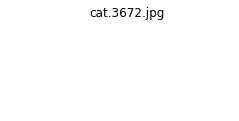

In [5]:
import math
plt.figure(figsize=(16, 16))
def show_image(img_path_list):
    for i, image_path in  enumerate(img_path_list):
#         print(i)
#         print(image_path)
        plt.subplot(10, 4, i+1)
        
        plt.title(image_path)
        plt.axis('off')
        img = mpimg.imread('train/' + image_path)
        imgplot = plt.imshow(img)


total_batch = math.ceil(len(my_unknow_images) / 40)
# print(total_batch)

# 分批人工审查
# batch=3 # 0 to 3
# show_image(my_unknow_images[batch*40:(batch+1)*40])

batch0_unknow = ['cat.3672.jpg','dog.9517.jpg','cat.5418.jpg','dog.6475.jpg','dog.10801.jpg','dog.5604.jpg','cat.6402.jpg']
batch1_unknow = ['dog.4367.jpg','dog.11299.jpg','cat.10712.jpg','cat.4338.jpg','cat.11184.jpg','dog.12376.jpg','cat.9171.jpg','cat.2337.jpg','cat.7377.jpg','dog.7727.jpg','cat.8456.jpg','dog.10161.jpg']
batch2_unknow = ['cat.5351.jpg','dog.3889.jpg','dog.1773.jpg','dog.1194.jpg','dog.1043.jpg','dog.9931.jpg','cat.4688.jpg','dog.8898.jpg','dog.6725.jpg','cat.12493.jpg','cat.10029.jpg']
batch3_unknow = ['dog.4507.jpg','dog.10237.jpg','dog.10747.jpg','cat.7564.jpg','cat.2520.jpg','cat.3216.jpg','cat.12272.jpg','dog.8736.jpg','cat.10700.jpg','cat.10539.jpg']

# 合并分批审核结果
final_unknow = batch0_unknow + batch1_unknow + batch2_unknow + batch3_unknow
print('异常图片共', len(final_unknow))

# 显示最终获得的异常图片
show_image(final_unknow)

#### 处理异常图片

In [35]:
# 把异常图片从train移动到unknown文件夹
def move_images_to(files, dest_path):
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
        
    for file in files:
        shutil.move("train/" + file, dest_path)
    
# files = ['cat.3.jpg','cat.5.jpg']
move_images_to(final_unknow, 'unknow')


#### 准备训练集，验证集，测试集

In [6]:


train_files = os.listdir('train')
test_files = os.listdir('test')

# 参考 http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
my_train_files, my_valid_files = train_test_split(train_files,test_size=0.2,random_state = 0)
print('my train data count:', len(my_train_files), '; my valid data count:', len(my_valid_files))

# my train data 细分为cat和dog
train_cat_list = [file if file.split('.')[0] == 'cat' else None for file in my_train_files]
train_cat_list = list(filter(None.__ne__, train_cat_list))
# train_cat_list = filter(partial(is_not, None), train_cat_list)

train_dog_list = [file if file.split('.')[0] == 'dog' else None for file in my_train_files]
train_dog_list = list(filter(None.__ne__, train_dog_list))
# train_dog_list = filter(partial(is_not, None), train_dog_list)

print('train cat count:', len(train_cat_list), '; train dog count:', len(train_dog_list))

# print(train_cat_list[0:10])
# print(train_dog_list[0:10])

# my valid data 细分为cat， dog
valid_cat_list = [file if file.split('.')[0] == 'cat' else None for file in my_valid_files]
valid_cat_list = list(filter(None.__ne__, valid_cat_list))

valid_dog_list = [file if file.split('.')[0] == 'dog' else None for file in my_valid_files]
valid_dog_list = list(filter(None.__ne__, valid_dog_list))

print('valid cat count:', len(valid_cat_list),'; valid dog count:', len(valid_dog_list))

# print(valid_cat_list[0:10])
# print(valid_dog_list[0:10])




my train data count: 19968 ; my valid data count: 4992
train cat count: 9955 ; train dog count: 10013
valid cat count: 2525 ; valid dog count: 2467


#### 文件目录分类

In [9]:
def my_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

my_mkdir('train_classify')
my_mkdir('train_classify/cat')
my_mkdir('train_classify/dog')
my_mkdir('valid_classify')
my_mkdir('valid_classify/cat')
my_mkdir('valid_classify/dog')
my_mkdir('test_nolabel')


for file in train_cat_list:
    os.symlink('../../train/' + file, 'train_classify/cat/' + file)
    
for file in train_dog_list:
    os.symlink('../../train/' + file, 'train_classify/dog/' + file)

for file in valid_cat_list:
    os.symlink('../../train/' + file, 'valid_classify/cat/' + file)

for file in valid_cat_list:
    os.symlink('../../train/' + file, 'valid_classify/dog/' + file)
    
for file in test_files:
    os.symlink('../test/' + file, 'test_nolabel/' + file)

# 对测试集预处理
def my_generator(resize,preprocess_type):
    X_test = []
    for file in tqdm(test_files):
        img = image.load_img('test_nolabel/'+file, target_size=resize)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
        if preprocess_type == 'InceptionResNetV2':
            x = inception_resnet_v2.preprocess_input(x)
        elif preprocess_type == 'Xception':
            x = xception.preprocess_input(x)
        elif preprocess_type == 'InceptionV3':
            x = inception_v3.preprocess_input(x)
        elif preprocess_type == 'ResNet50':
            x = resnet50.preprocess_input(x)
        X_test.append(x)


    gen = ImageDataGenerator() # 参考 https://keras.io/zh/preprocessing/image/#imagedatagenerator
    train_generator = gen.flow_from_directory(directory="train_classify", 
                                              target_size=resize, 
                                              shuffle=False, 
                                              batch_size=32,
                                              class_mode="categorical")

    valid_generator = gen.flow_from_directory(directory='valid_classify',
                                                   target_size=resize,
                                                   shuffle=False, 
                                                   batch_size=32,
                                                   class_mode='categorical')

    test_generator = gen.flow_from_directory(directory="test_nolabel",
                                             target_size=resize, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             class_mode=None)
    return X_test, train_generator, valid_generator, test_generator

# X_test, train_generator, valid_generator, test_generator = my_generator((299, 299),'InceptionResNetV2')
# X_test, train_generator, valid_generator, test_generator = my_generator((299, 299),'InceptionV3')
# X_test, train_generator, valid_generator, test_generator = my_generator((224, 224),'ResNet50')

train_classify_files = os.listdir('train_classify/cat')
valid_classify_files = os.listdir('valid_classify/cat')
print('my train data count:', len(train_classify_files), '; my valid data count:', len(valid_classify_files))

my train data count: 9955 ; my valid data count: 2525


## 步骤 2: 模型探索

#### InceptionResNetV2探索

In [ ]:
# 构建不带分类器的预训练模型
x = Input(shape=(299, 299, 3))
x = Lambda(inception_resnet_v2.preprocess_input)(x)
base_model = InceptionResNetV2(input_tensor=x, weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
    
# 添加全局平均池化层
x = GlobalAveragePooling2D()(base_model.output)
# 添加Dropout
x = Dropout(0.5)(x)
# 添加一个分类器
predictions = Dense(2, activation='sigmoid')(x)
# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)
# 编译模型
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

# model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)
# X_train, y_train = shuffle(X_train, y_train)

#训练模型并保存具有最佳验证loss的模型权重
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionResNetV2.hdf5', 
                               verbose=1, save_best_only=True)
model.fit_generator(train_generator,
                    epochs=5,
                    validation_data=valid_generator,
                    callbacks=[checkpointer])


Epoch 1/5
624/624 [==============================] - 714s 1s/step - loss: 0.7868 - acc: 0.5256 - val_loss: 0.7285 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.72851, saving model to saved_models/weights.best.InceptionResNetV2.hdf5


KeyboardInterrupt: 

In [ ]:
# 加载具有最佳验证loss的模型权重
model.load_weights('saved_models/weights.best.InceptionResNetV2.hdf5')

y_pred = model.predict(X_test, verbose=1)
# 将每个预测值限制到了 [0.005, 0.995] 个区间内，这个原因很简单，kaggle 官方的评估标准是 LogLoss，
# 对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大，是 15 和 2 的差别。
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html
y_pred = y_pred.clip(min=0.005, max=0.995)

In [31]:
df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

NameError: name 'pd' is not defined

#### InceptionV3探索

In [15]:
# gen = ImageDataGenerator()
# 这里要设置class_mode="binary"(二分类问题), 如果设置class_mode="categorical", 那么下面Dense神经元设置1个会报错
# gen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input)
gen = ImageDataGenerator(rescale=1.0/255)
train_generator = gen.flow_from_directory(directory="train_classify", 
                                            target_size=(299, 299), 
                                            batch_size=32,
                                            class_mode="binary")

valid_generator = gen.flow_from_directory(directory='valid_classify',
                                               target_size=(299, 299),
                                               batch_size=32,
                                               class_mode='binary')
x = Input(shape=(299, 299, 3))
# x = inception_v3.preprocess_input(x)

base_model = InceptionV3(input_tensor=x, weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

# 添加全局平均池化层
x = GlobalAveragePooling2D()(base_model.output)
# 添加Dropout
x = Dropout(0.5)(x)
# 添加一个分类器
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5',
                               verbose=1, save_best_only=True)
# model.fit_generator(train_generator,
#                     epochs=5,
#                     validation_data=valid_generator,
#                     callbacks=[checkpointer])
model.fit_generator(
        train_generator,
        samples_per_epoch=2048,
        nb_epoch=10,
        validation_data=valid_generator,
        nb_val_samples=1024,
        callbacks=[checkpointer])

Found 19968 images belonging to 2 classes.
Found 5050 images belonging to 2 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:44: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=64, epochs=10, validation_steps=1024)`


Epoch 1/10
64/64 [==============================] - 414s 6s/step - loss: 0.4123 - acc: 0.8315 - val_loss: 1.5902 - val_acc: 0.5005

Epoch 00001: val_loss improved from inf to 1.59020, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/10
64/64 [==============================] - 405s 6s/step - loss: 0.2222 - acc: 0.9316 - val_loss: 2.2739 - val_acc: 0.5001

Epoch 00002: val_loss did not improve from 1.59020
Epoch 3/10
64/64 [==============================] - 405s 6s/step - loss: 0.1892 - acc: 0.9370 - val_loss: 2.5419 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 1.59020
Epoch 4/10
63/64 [============================>.] - ETA: 0s - loss: 0.1553 - acc: 0.9494

KeyboardInterrupt: 

#### Xception探索

## 步骤 3: 模型搭建

上面单独使用了Resnet50, InceptionV3, Exception模型进行尝试，成绩都不是太理想；
下面会综合三个模型的特征来搭建一个全新的模型进行预测。

## 步骤 4: 模型训练

## 步骤 5: 模型调参

## 步骤 6: 模型评估

### 预测测试集

## 步骤 7: 可视化